# Figure 2

**Figure 2 | Trial-by-trial spiking-to-LFP simulation and correlation with sEEG.** (A) Trial-wise LFP simulation technique. LFPs are simulated to represent each model under the conditions of a given trial. The onsets of tones in each trial are determined by the trial parameters (number of tones, IOI, and jitter). The trial depicted here has five tones, an IOI of 500 ms, and a target tone jitter of 200 ms. Each tone is 200 ms long. The probability of a spike occurring during the trial is generated for each model given the trial parameters (see Methods). The spike probability signal is then interpolated with a population of 100 randomly-spiking neurons (ten are shown here). Each spike is convolved with a voltage kernel representing the excitatory postsynaptic potential of an AMPA receptor, reflecting both corticopetal excitatory drive, and top-down excitatory drive from association cortex, onto auditory cortex. The convolved spiking signals for all neurons are then summed to generate the simulated LFP for the trial (see panel B). (B) Simulated LFPs for the trial depicted in panel A for each model: Bottom-up sensory input (blue), top-down bias (salmon), and the SAMy dynamical systems model (magenta). (C) Comparison of simulated LFPs with sEEG. Three trials from three different electrodes are depicted, each with the simulated LFP (colors same as panel B) and the raw, unfiltered sEEG signal (black). Voltages from simulations are normalized between zero and one, like panel B. sEEG voltages are displayed in microvolts, as recorded from the bipolar contact pair midpoint. The Spearman correlation coefficient (ρ) represents the strength of the similarity between the two signals, where a strong negative correlation indicates a signal with opposite voltage, suggesting a putative dipole (see blue, bottom-up signal). (D) Estimated cortical location of sEEG depth electrodes, the sources of the sEEG signals (black) depicted in panel C. Colors indicate the source of the sEEG signals compared to the simulated LFPs displayed in panel C.


### imports

In [23]:
import numpy as np
from neurodsp import sim
#from neurodsp.utils.data import create_times, compute_nsamples
#from neurodsp.timefrequency import amp_by_time
#from fooof import FOOOF

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0,'../../01-scripts/')
from prophecy_functions import *

In [24]:
sns.set_context('poster')

### analysis functions

In [25]:
n_tones = 5 #number of tones in the trial
stim_length = 200 #length of auditory stimulus
isi_length = 500 #interstimulus (inter-onset) interval of tone sequence in ms
soa_length = 200 #soa (jitter)
fs = 1000 # sampling frequency
edge_length = 200 #time before trial start and end of tones
trial_length = 5200 # total length of trial in ms

n_neurons = 100 #neurons in each population converging

fr_rest = 0.05 #minimum probability of neuron spiking at any point
fr_stim = 0.5  #maximum probability of neuron spiking at any point

tau_r = 0.0001 #rise timescale of synaptic kernel
tau_d = 0.002 #decay timescale of synaptic kernel
t_ker = 0.05 #total duration of synaptic kernel

adapt_rate = 0.2 #adaptation rate (bottom-up)
sens_rate = 0.2 #sensitization rate (top-down, height of gauss)
learning_rate = 0.15 #learning rate (top-down, width of gauss)

# generate tone onsets and kernel
tone_onsets_tp = get_tone_onsets_tp(n_tones, stim_length, isi_length, soa_length, edge_length)
tone_onsets_btm = get_tone_onsets_btm(n_tones, stim_length, isi_length, soa_length, edge_length)
ker = sim.sim_synaptic_kernel(t_ker, fs, tau_r, tau_d)

In [40]:
times = np.arange(0,trial_length)

n_trials = 1

combined_lfps = np.zeros(shape=[n_trials,trial_length])
tp_lfps = np.zeros(shape=[n_trials, trial_length])
btm_lfps = np.zeros(shape=[n_trials, trial_length])

for trial in range(0,n_trials):

    tp_neurons = np.zeros(shape=[n_neurons,trial_length])
    btm_neurons = np.zeros(shape=[n_neurons,trial_length])

    for neuron in range(0,n_neurons):
        
        tp_prob, tp_signal = sim_top_down(tone_onsets_tp, fs, stim_length, learning_rate, trial_length,
                                    fr_rest, fr_stim, sens_rate, ker)
        tp_neurons[neuron,:] = tp_signal

        btm_prob, btm_signal = sim_bottom_up(tone_onsets_btm, fs, stim_length, trial_length,
                                     fr_rest, fr_stim, adapt_rate, ker)
        btm_neurons[neuron,:] = btm_signal

    tp_lfps[trial,:] = tp_neurons.sum(0)
    btm_lfps[trial,:] = btm_neurons.sum(0)
    

In [41]:
trial_info = {'SOA': 500,
              'Standard #': 4,
              'SOA Jitter': 700.0}

sam_lfp, sam_lfp_e, sam_lfp_i = simulate_sam_lfp(trial_info, trial_length)

### plotting functions

In [42]:
def plot_tone_onsets(tone_onsets_btm, stim_length, fs):
    plt.figure(figsize=[12,3])
    plt.xlabel('time (s)')
    plt.title('♪ ON/OFF')
    plt.xlim([0,2.9])
    for t in tone_onsets_btm:
        plt.axvspan(tone_onsets_btm[t]/fs, (tone_onsets_btm[t]+stim_length)/fs, color='teal', alpha=0.3)

def plot_kernel(ker):
    plt.figure(figsize=[3,3])
    plt.xlabel('time (ms)')
    plt.ylabel('$\mu$V')
    plt.title('kernel')
    plt.plot(ker, color='salmon')

def plot_spiking_neurons(tp_neurons, n_neurons):
    plt.figure(figsize=[12,3])
    for i, neuron in enumerate(tp_neurons[:n_neurons]):
        plt.plot(times/1000, neuron+i, color='k', alpha=0.3, lw=1)
    plt.xlim(0, 2.9)
    plt.yticks([])
    plt.title('neurons')
    plt.xlabel('time (s)')

def plot_sim_lfps(btm_neurons, tp_neurons, sam_lfp, fs, tone_onsets_btm):
    pltsigs = [normalize_waveform(btm_neurons.sum(axis=0)),
               normalize_waveform(tp_neurons.sum(axis=0)),
               normalize_waveform(sam_lfp[600:-100])] #time window adjustment 
    colors = ['dodgerblue', 'salmon', 'mediumvioletred']

    fig, axs = plt.subplots(3,1,figsize=[12,9], sharex=False, sharey=True)
    fig.supxlabel('time (s)')
    fig.supylabel('normalized voltage')
    
    for i, pltsig in enumerate(pltsigs):
    
        if i==2:
            axs[i].plot(times[:-700]/fs, pltsig, color=colors[i], alpha=1.0)
        else:
            axs[i].plot(times/fs, pltsig, color=colors[i], alpha=1.0)
        
        for t in tone_onsets_btm:
            axs[i].axvspan(tone_onsets_btm[t]/1000, (tone_onsets_btm[t]+200)/1000, color='teal', alpha=0.3)
    
        axs[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True)) 
        axs[i].tick_params(axis='x', labelsize=15)
    
        axs[i].set_xlim([0,2.9])
        axs[i].set_ylim([-0.1, 1.1])
    
    fig.suptitle('Simulated LFPs')

<>:12: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\m'
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_96123/2932769919.py:12: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$V')


# panel A

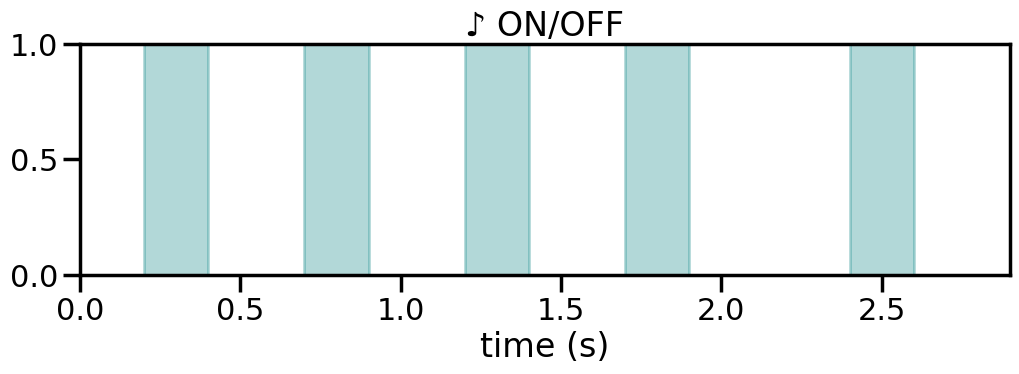

In [43]:
plot_tone_onsets(tone_onsets_btm, stim_length, fs)

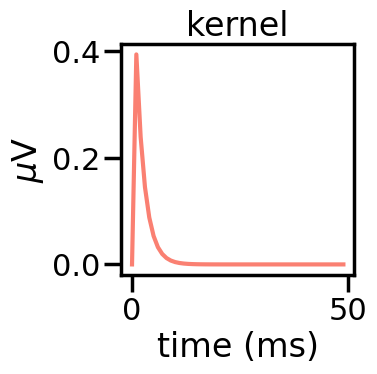

In [44]:
plot_kernel(ker)

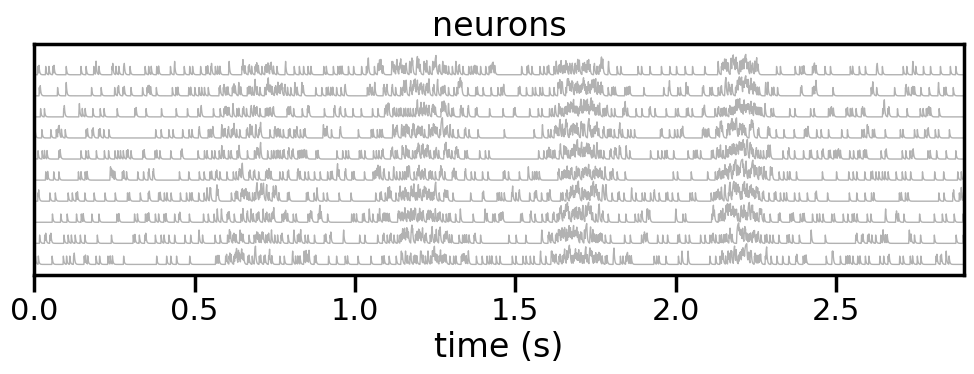

In [45]:
plot_spiking_neurons(tp_neurons, n_neurons=10)

# panel B

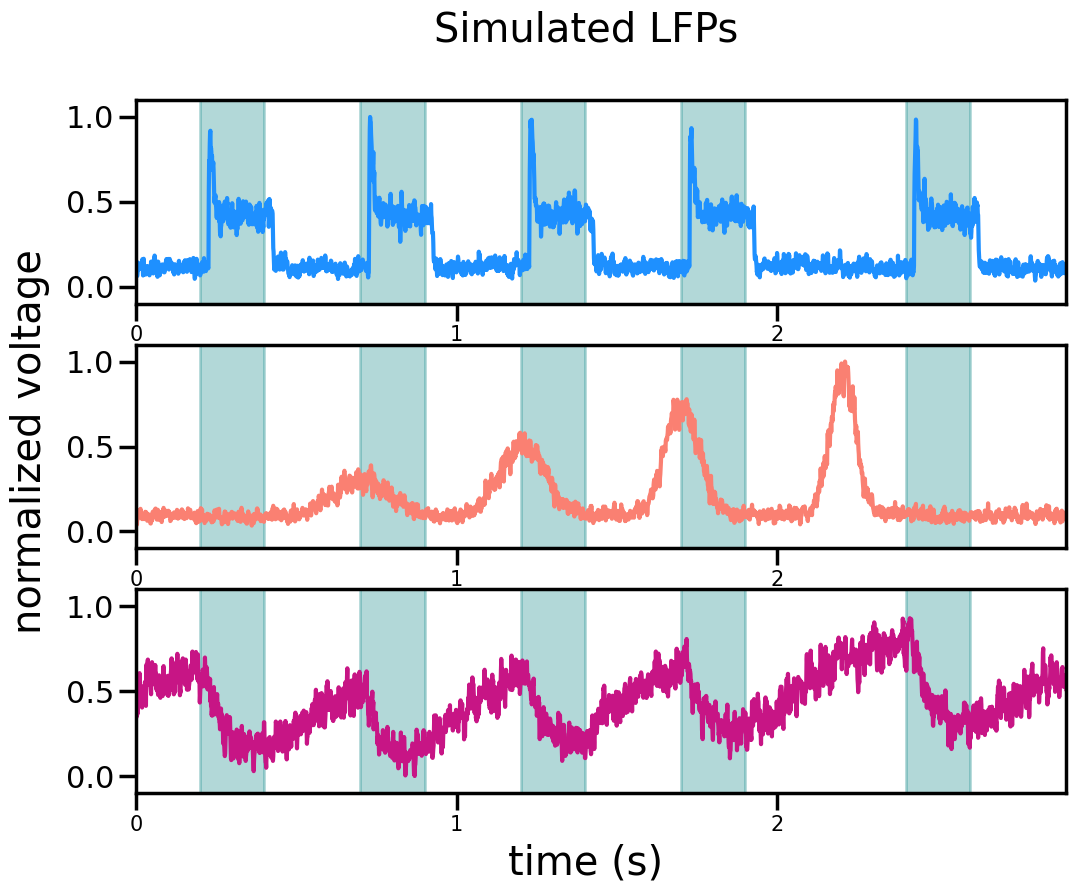

In [46]:
plot_sim_lfps(btm_neurons, tp_neurons, sam_lfp, fs, tone_onsets_btm)

# panel C

# panel D

This panel contains sEEG electrode location information, and these data are available upon reasonable request, subject to IRB approval.